# Structure prediction in the *sce* dataset 
This notebook shows the results for predicted structures of RNAs in the *sce* dataset, for each method in the review, using the PARS-guided structure and PARS-score as reference.

## Setup

In [1]:
!pip -q install biopython
!pip -q install path
!pip -q install Orange3
!pip install wget

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import wget
from Bio import SeqIO
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import Orange 
from scipy.stats import friedmanchisquare

# Download and decompress RNAstructure
!wget -q http://rna.urmc.rochester.edu/Releases/current/RNAstructureLinuxTextInterfaces64bit.tgz
!tar xfz RNAstructureLinuxTextInterfaces64bit.tgz

repository_path = "https://raw.githubusercontent.com/sinc-lab/lncRNA-folding/main/"


     |████████████████████████████████| 2.3 MB 25.8 MB/s 
     |████████████████████████████████| 28.6 MB 5.8 MB/s 
     |████████████████████████████████| 2.4 MB 30.1 MB/s 
     |████████████████████████████████| 491 kB 44.3 MB/s 
     |████████████████████████████████| 77 kB 4.7 MB/s 
     |████████████████████████████████| 992 kB 42.5 MB/s 
     |████████████████████████████████| 149 kB 50.7 MB/s 
     |████████████████████████████████| 48 kB 1.2 MB/s 
     |████████████████████████████████| 8.3 MB 40.8 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 228 kB 11.2 MB/s 
     |████████████████████████████████| 252 kB 43.5 MB/s 
     |████████████████████████████████| 58 kB 2.3 MB/s 
     |████████████████████████████████| 79 kB 2.0 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
     |████████████████████████████████| 59.9 MB 114 kB/s 
     |████████████████████

## Auxiliary functions

In [2]:
def rnastructure_scorer(reference_fasta, prediction_fasta):
    """
    Compares reference and predicted structures and returns RNAstructure scores
   
    Parameters
    ----------
    reference_fasta : str
        Fasta filename with seq_id, sequence and structure with reference
    prediction_fasta : str
        Fasta filename with seq_id, sequence and structure with prediction

    Returns
    -------
    s, p, f1
        Base-pairing sensibility, precision and f1-score
    """
    # Convert input dot files into ct files
    # http://rna.urmc.rochester.edu/Text/File_Formats.html#CT
    tab_path = "RNAstructure/data_tables"
    dot2ct_path = "RNAstructure/exe/dot2ct"
    scorer_path = "RNAstructure/exe/scorer"

    os.system(f"export DATAPATH={tab_path}; {dot2ct_path} {prediction_fasta} tmp_pred.ct")
    os.system(f"export DATAPATH={tab_path}; {dot2ct_path} {reference_fasta} tmp_true.ct")

    # Calculate metrics
    s, p, f1 = 0, 0, 0  # if the predictions are invalid and the scorer fails, scores are 0 
    os.system(f"export DATAPATH={tab_path}; {scorer_path} tmp_pred.ct tmp_true.ct tmp_score.txt")
    if os.path.isfile("tmp_score.txt"): # scorer exited sucessfully
        for line in open('tmp_score.txt'):
            if 'Sensitivity' in line:
                s = float(line.strip().split()[-1][:-1])/100
            if 'PPV' in line:
                p = float(line.strip().split()[-1][:-1])/100
        if s + p != 0:
            f1 = 2*s*p/(s + p)
        
    # clean tmp files
    for f in os.listdir("./"):
        if "tmp_" in f:
            os.remove(f)

    return s, p, f1

def split_fasta_seq(seq_str):
    """
    split sequence id, sequence and structure from string
   
    Parameters
    ----------
    seq_str : str
        String as read from SeqIO.parse
    
    Returns
    -------
    seq, struct
        Sequence and structure strings
    """
    ind = re.search("[.()\[\]{}<>]", seq_str).start()

    seq = seq_str[:ind].lower().replace('t', 'u')
    struct = seq_str[ind:ind*2]
    
    return seq, struct

def write_fasta(fname, seqid, seq, struct):
    """
    Writes fasta file using one item per line

    Parameters
    ----------
    fname : str
        Output filename
    seqid, seq, struct : str
        Sequence id, sequence and structure to write
    """
    with open(fname, "w") as fin:
        fin.write(f">{seqid}\n")
        fin.write(f"{seq}\n")
        fin.write(f"{struct}\n")

## Mean Absolute Similarity (MAS) score and probing normalization

In [3]:
def scale_probing(scores, source):
    """
    Scale the structural probing scores in the range [0, 1], where 0 is not 
    paired and 1 is paired.
        
    Parameters
    ----------
    scores : array[float]
        Structural probing scores, same size as the RNA sequence
    source : str
        Probing method from the following:

        'PARS': original log scale (cite2010)
        
        'nextPARS': from linear scores (SHAPE-like by Uciel Chorostecki2021 https://doi.org/10.1007/978-1-0716-1307-8_4)
                    "score for each nucleotide that ranges from −1.0 (highest preference for single strand)
                    to 1.0 (highest preference for double-strand)."
                    https://github.com/Gabaldonlab/nextPARS_docker
        
        'SHAPE': input scores in (0,1) 0=>match (double strand) and 1=>non-match (single strand)
                (Chillon2015 https://dx.doi.org/10.1016/bs.mie.2015.01.008)
                preprocessing: https://colab.research.google.com/drive/1uFgjb4uesAvYHPRhFqfkyMJ5bQec8rgP
                - mark with -999 the undetermined nucleotides
                - remove negative values (replace with -999)
                - replace scores>1 with 1.0
                - (do not scale/transform values in the range (0,1) because they have a particular meaning in the standard.
                output 1-score
        'SHAPE-D': apply ln and then linear scale
                (Deigan2009 https://doi.org/10.1073/pnas.0806929106)
                (default in RNAfold https://www.tbi.univie.ac.at/RNA/RNAfold.1.html)
                [HOTAIR, PAN]?
        
        np.nan: nt without measurement => assing 0.5 (then exclude them with tol>0.0
        in the MAS function)
    
    Returns
    -------
    nscores
        Normalized scores
    """
    s = scores.copy()
    
    if source=="PARS":
        nscores = (s + 7) / (2*7)
    elif source=="nextPARS":
        nscores = (s + 1) / 2 
    elif source=="SHAPE":
        nscores = 1 - s
    elif source=="SHAPE-D":
        shD = 1.8*np.log(s+1)-0.6
        shD[shD<-2.0] = -2.0
        shD[shD>2.0] = 2.0
        nscores = (shD+2.0)/4.0
    else:
        print("WARNING: scaling not applied")
        nscores = s

    nscores[np.isnan(nscores)] = 0.5    
    return nscores 
    
def mas_score(pred, nscores, tol=0.1):
    """
    Mean absolute similarity (MAS) between binary predictions and biochemical 
    probing scores.   

    Parameters
    ----------
    pred : array[int]
        Paired-unpaired prediction for each nucleotid in {0, 1}, where 0 is 
        unpaired and 1 is paired
    nscores : array[float]
        Probing score for each nucleotid in [0, 1], where 0 is high score for 
        unpaired and 1 high score for paired
    tol : float
        Nucleotids with (0.5 - tol/2) < score < (0.5 + tol/2)  are ignored
    
    Returns
    -------
    MASu, MASp, MAS : float
        paired MAS, unpaired MAS and average MAS. 
    """
    i_pos = nscores > 0.5 + tol/2
    i_neg = nscores <= 0.5 - tol/2
    Npos = sum(i_pos)
    Nneg = sum(i_neg)
       
    diff = pred - nscores
    
    mas_pos = 1 - np.absolute(diff[i_pos]).mean()
    mas_neg = 1 - np.absolute(diff[i_neg]).mean()
    
    # best and worst cases for normalization
    ref_ideal = np.ones((len(nscores),))
    ref_ideal[nscores<=tol/2+0.5] = 0.0
    
    diff_ideal = ref_ideal - nscores
    diff_worst = (1-ref_ideal) - nscores
    
    max_mas_pos = 1 - np.absolute(diff_ideal[i_pos]).mean() 
    max_mas_neg = 1 - np.absolute(diff_ideal[i_neg]).mean()     
    min_mas_pos = 1 - np.absolute(diff_worst[i_pos]).mean() 
    min_mas_neg = 1 - np.absolute(diff_worst[i_neg]).mean()     
    
    MASp = (mas_pos - min_mas_pos) / (max_mas_pos - min_mas_pos) 
    MASu = (mas_neg - min_mas_neg) / (max_mas_neg - min_mas_neg) 
    
    # simple average
    ave_mas = 1 - np.absolute(diff[i_pos | i_neg]).mean() 
    
    # normalized average
    max_ave_mas = 1 - np.absolute(diff_ideal[i_pos | i_neg]).mean()
    min_ave_mas = 1 - np.absolute(diff_worst[i_pos | i_neg]).mean()
    MAS = (ave_mas - min_ave_mas) / (max_ave_mas - min_ave_mas) 

    return MASp, MASu, MAS

## Prepare dataset and predictions
This section retrieves the references, probing scores (PARS) and the predicted structures for a list of sequences. 

Three overlapping sets have been selected from sce:

- "sce3k": All the unique sce sequences with at least 200 nt 
- "sce188": A subset of 188 long RNA sequences and a set of mRNA with potential non-coding function.
- "sce18": A subset of 18 lncRNA sequences


In [5]:
# Select one subset of the following:

#subset = "sce3k" 
subset = "sce188" 
#subset = "sce18" 

# Load references
references = pd.read_csv(f"{repository_path}data/sce_genes_folded.tab", delimiter='\t', 
                  header=None, index_col=0, 
                  names=("ID", "sequence", "structure"))

# Normalize sequences
references.sequence = references.sequence.str.lower().replace('t', 'u')

# Filter the subset IDs 
IDs = pd.read_csv(f"{repository_path}data/{subset}.txt", header=None)[0].values
references = references.loc[IDs]

print(f"Total number of sequences in {subset}:", len(references))

# Reviewed methods sorted by publication date. E2Efold and 2dRNA-Fold were 
# removed because the median F1-value is < .1 in every subset. 
methods = ['CONTRAFold', 'CentroidFold', 'ProbKnot', 'ShapeKnots', 'RNAstructure',
           'contextFold', 'IPknot', 'RNAfold', 'pKiss', 'RNAshapes',
           'LinearFold', 'SPOT-RNA', 'LinearPartition',
           'rna-state-inf', 'MXfold2', 'SPOT-RNA2', 'UFold']

# Load all predictions
predictions = {}
for method in tqdm(methods):
    
    predictions[method] = {}
    prediction_fasta =  f"{method}.fasta"
    
    if not os.path.isfile(prediction_fasta):
         wget.download(f"{repository_path}predictions/sce/{method}.fasta")

    # Read each sequence structure
    for record in SeqIO.parse(prediction_fasta, "fasta"):
        if record.id not in references.index:
            continue
        seq, struct = split_fasta_seq(str(record.seq))        
        predictions[method][record.id] = struct

Total number of sequences in sce188: 188


  0%|          | 0/17 [00:00<?, ?it/s]

In [6]:
# PARS scores: these are used to evaluate if the methods match the paired or 
# unpaired status of specific nucleotid positions
# Original source: https://genie.weizmann.ac.il/pubs/PARS10/data/sce_Score.tab.gz
probing_scores_raw = pd.read_csv(f"{repository_path}data/sce_PARS_score.tab", delimiter='\t', 
                  index_col=0)
probing_scores = {}
for ID in probing_scores_raw.index:
    score = np.array(probing_scores_raw.loc[ID, "score"].split(";"), dtype=float)
    probing_scores[ID] = scale_probing(score, "PARS")

## Computing comparison metrics




In [7]:
tmp_pred = f"pred.fold"
tmp_ref = f"ref.fold"

results = []        

for method in tqdm(methods):
   for ID in predictions[method]:
        
        sequence = references.loc[ID].sequence
        struct_reference = references.loc[ID].structure 
        struct = predictions[method][ID]

        # MAS score
        pairing_prediction = [0 if n == "." else 1 for n in struct]
        MASp, MASu, MAS = mas_score(pairing_prediction, probing_scores[ID])

        # Remove pseudoknots for structure comparison
        for c in np.unique(list(struct)):
            if c not in ["(", ")", "."]:
                struct = struct.replace(c, ".")
        
        # Write a fasta with an unique sequence to run the scorer
        write_fasta(tmp_pred, ID, sequence, struct) # Prediction        
        write_fasta(tmp_ref, ID, sequence, struct_reference) # Label
        
        # Base-pairing prediction results
        s, p, f1 = rnastructure_scorer(tmp_ref, tmp_pred)
        
        results.append([ID, method, MASp, MASu, MAS, s, p, f1])

        os.remove(tmp_pred)
        os.remove(tmp_ref)

results = pd.DataFrame(results, columns=["ID", "Method", "MAS-paired", 
                                         "MAS-unpaired", "MAS", "Sensibility", 
                                         "Precision", "F1"])

  0%|          | 0/17 [00:00<?, ?it/s]

## Results analysis

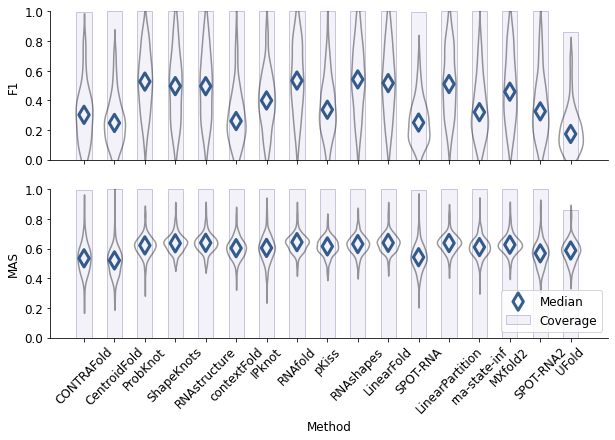

In [9]:
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)

# Coverage
nc = results.loc[:, ['Method', 'F1']].groupby(by='Method', sort=False).count().values
coverage = np.squeeze(nc/len(results.ID.unique()))

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

for ax, metric in zip(axes, ["F1", "MAS"]):
    
    ax.bar(np.arange(len(coverage)), coverage, color=[.0, .0, .5, .05],
        edgecolor=[.0, .0, .5, .2], width=.5, label="Coverage")

    sns.violinplot(data=results, x="Method", y=metric, width=.8, 
                color="white", edgecolor="black", inner=None, ax=ax)

    if subset == "sce18":
        sns.swarmplot(data=results, x="Method", y=metric, color="gray", ax=ax, 
                      zorder=1)

    median = results.groupby(by="Method", sort=False)[metric].median()

    ax.scatter(x=range(len(median)), y=median, marker="d", facecolors="none", 
                edgecolors=plt.cm.viridis(.3), s=150, linewidth=3, label="Median")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim([0, 1])
    ax.set_xlabel("")

plt.legend(loc="lower right")
plt.xticks(np.arange(len(results["Method"].unique())), rotation=45);
plt.xlabel("Method");


## Critical Difference

Friedman test in F1: pvalue= 0.00
Friedman test in MAS: pvalue= 0.00


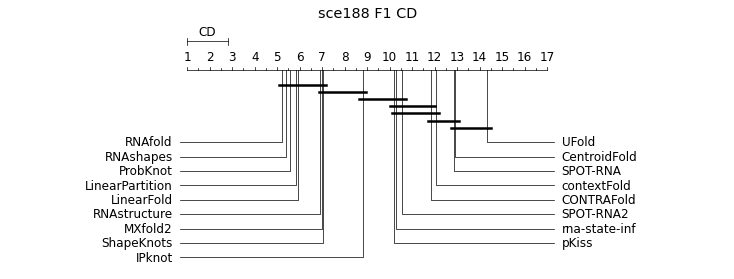

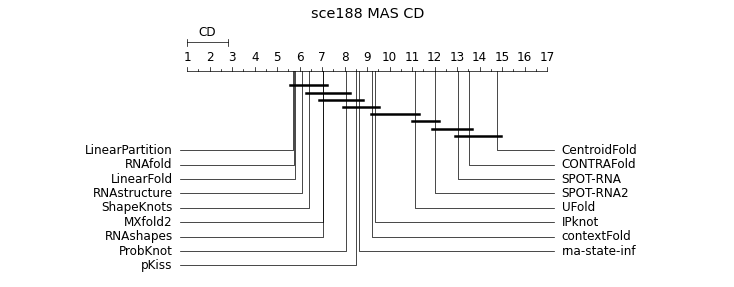

In [10]:
for metric in ["F1", "MAS"]:
    cols = ['ID', 'Method', metric]
    results_list = results.loc[:, cols].pivot(index="ID", 
                                              columns="Method").values.tolist()
    pvalue = friedmanchisquare(*results_list).pvalue
    print(f"Friedman test in {metric}: pvalue={pvalue: .2f}")

    avranks = results.loc[:, cols].set_index('Method').groupby(by='ID').rank(ascending=False).groupby('Method').mean()
    names = avranks.index
    avranks = np.squeeze(avranks.values)
    cd = Orange.evaluation.compute_CD(avranks, len(results.ID.unique()), 
                                      alpha="0.05", test="nemenyi") 
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=10, textspace=2.5, 
                                  cdmethod=None);
    plt.title(f"{subset} {metric} CD")


## Similarity of predicted structure between methods

  0%|          | 0/17 [00:00<?, ?it/s]

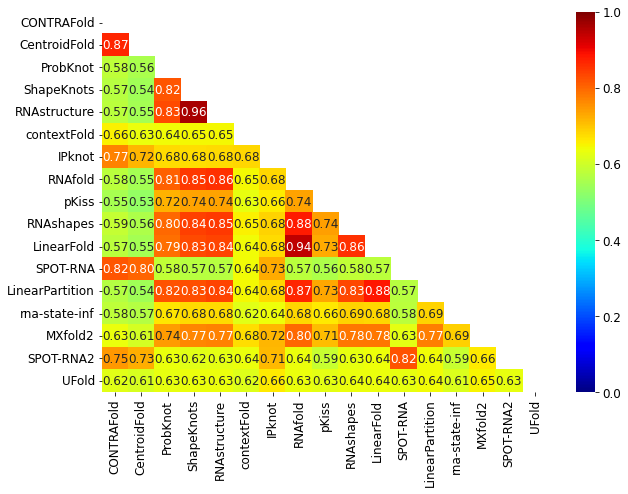

In [12]:
corrmat = np.zeros((len(methods), len(methods)))
for i, method1 in enumerate(tqdm(methods)):
    for j, method2 in enumerate(methods): 
        if j >= i:
            continue
        similarity = []
        for ID in predictions[method1].keys():
            if ID not in predictions[method2].keys():
                continue

            # paired-unpaired accuracy
            pred1 = np.array([0 if n == "." else 1 for n in predictions[method1][ID]])
            pred2 = np.array([0 if n == "." else 1 for n in predictions[method2][ID]])
            similarity.append(np.mean(pred1 == pred2))
            
        corrmat[i, j] = np.mean(similarity)
    
plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat, xticklabels=methods, yticklabels=methods, 
            mask=mask, annot=True, fmt='.2f', cmap="jet", vmin=0, vmax=1);